In [1]:
import os
import json
import sys
import re
import pandas as pd
import matplotlib.pyplot as plt
import collections
data_path="/opt/ml/data/"
context_path= "wikipedia_documents.json"
with open(os.path.join(data_path, context_path), "r", encoding="utf-8") as f:
    wiki = json.load(f)

## Data

In [2]:
wiki_data = {}

for key in wiki.keys() :
    data = wiki[key]
    wiki_data[data['document_id']] = data['text']

In [3]:
wiki_texts = []
for key in wiki_data.keys() :
    wiki_texts.append(wiki_data[key])

In [4]:
from transformers import AutoConfig, AutoModelForQuestionAnswering, AutoTokenizer
from transformers import (
    TrainingArguments,
    set_seed,
)

In [5]:
sys.path.append('../')
from datasets import load_metric, load_from_disk, Dataset, DatasetDict
from arguments import (
    ModelArguments,
    DataTrainingArguments,
)

In [6]:
model_args, data_args, training_args = ModelArguments, DataTrainingArguments, TrainingArguments
set_seed(training_args.seed)

In [7]:
datasets = load_from_disk('/opt/ml/data/train_dataset')
print(datasets)

DatasetDict({
    train: Dataset({
        features: ['__index_level_0__', 'answers', 'context', 'document_id', 'id', 'question', 'title'],
        num_rows: 3952
    })
    validation: Dataset({
        features: ['__index_level_0__', 'answers', 'context', 'document_id', 'id', 'question', 'title'],
        num_rows: 240
    })
})


## Tokenizer

In [8]:
tokenizer = AutoTokenizer.from_pretrained('klue/roberta-large', use_fast=True)
print(tokenizer)

PreTrainedTokenizerFast(name_or_path='klue/roberta-large', vocab_size=32000, model_max_len=512, is_fast=True, padding_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


## Preprocessor

In [9]:
from preprocessing import PreprocessorBase, PreprocessorMecab

In [10]:
wiki_base_text = PreprocessorBase.preprocessing(wiki_texts, "13", False)

In [11]:
datasets.cleanup_cache_files()
base_p_datasets = PreprocessorBase.preprocessing(datasets, pt_num = '13', chn_flag = False)

## Retrieval

In [12]:
from retrieval import SparseRetrieval

In [13]:
base_retriever = SparseRetrieval(tokenize_fn = tokenizer.tokenize, 
    data_path = '/opt/ml/data/',
    context_path = 'wikipedia_documents.json',
    pt_num = "13",
    split_special_token_flag = True)

Preprocessing Data
Lengths of unique contexts : 56329


In [14]:
# making sparse BM25 bin file
base_retriever.get_sparse_BM25()

BM25 Embedding pickle /opt/ml/data/BM25_embedding_13.bin loaded.


In [41]:
train_data = base_p_datasets['train']

In [42]:
train_base_retrieved = base_retriever.retrieve_BM25(train_data, topk=10)

Build BM25 score, indices



[query exhaustive search] done in 2191.579 s


## Visualize Recall@k

In [43]:
def get_recall_k(retrieved) :
    data_size = len(retrieved)
    pos_data = []
    for i in range(data_size) :
        data = retrieved.iloc[i]
        org_text = data['original_context']
        con_text = data['context'].split(' [SPLIT] ')

        if org_text in con_text :
            idx = con_text.index(org_text)
            pos_data.append(idx)
        else :
            pos_data.append(-5)

    out_pos_data = [pos for pos in pos_data if pos == -5]
    recall_k = (len(pos_data) - len(out_pos_data)) / len(pos_data)
    print("Probability of Recall-Top10 : %.3f" %recall_k)
    
    return pos_data


In [44]:
def visualize(pos_data, name) :
    counter = collections.Counter()
    counter.update(pos_data)
    count_items = sorted(counter.items(), key = lambda x : x[0])

    plt.figure(figsize = (8,6))
    x_vals = [item[0] for item in count_items]
    y_vals = [item[1] for item in count_items]

    plt.bar(x_vals, y_vals, 0.75, color = "skyblue")
    plt.title(name, fontsize=15)
  
    for i in range(len(y_vals)):
        y_val = y_vals[i]
        x_val = x_vals[i]
        plt.text(x_val , y_val+3, str(y_val), 
            color = 'blue', fontweight = 'bold')
    plt.show()

Probability of Recall-Top10 : 0.892


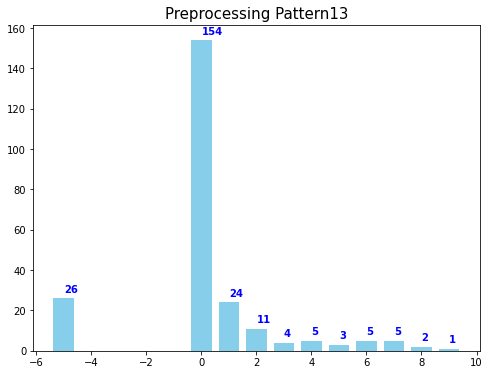

In [45]:
base_pos_data = get_recall_k(val_base_retrieved)
visualize(base_pos_data, "Preprocessing Pattern13")

In [46]:
train_base_retrieved = base_retriever.retrieve_BM25(train_data, topk=20)

Build BM25 score, indices



[query exhaustive search] done in 2137.013 s


Probability of Recall-Top10 : 0.907


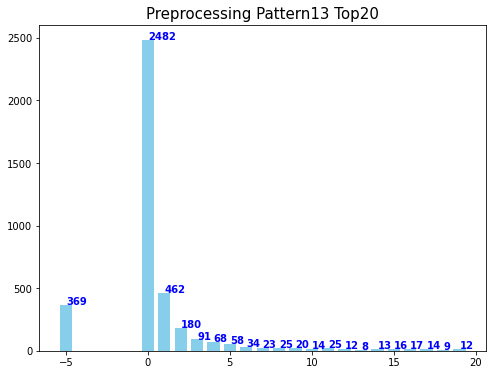

In [47]:
base_pos_data = get_recall_k(train_base_retrieved)
visualize(base_pos_data, "Preprocessing Pattern13 Top20")

In [48]:
train_base_retrieved = base_retriever.retrieve_BM25(train_data, topk=30)

Build BM25 score, indices



[query exhaustive search] done in 2251.311 s


Probability of Recall-Top10 : 0.920


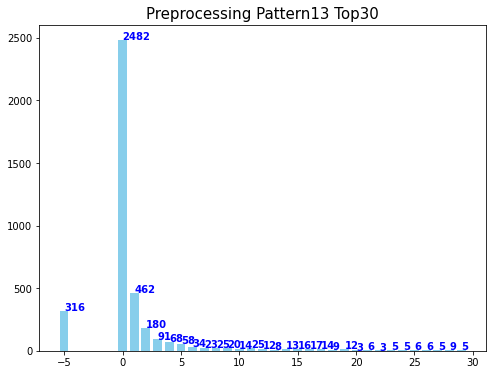

In [49]:
base_pos_data = get_recall_k(train_base_retrieved)
visualize(base_pos_data, "Preprocessing Pattern13 Top30")